# Relatório Final – Analise de dados sobre capacitação - STM
Igo Costa;
Luciana;
Rafael Carvalho dos Santos;
Introdução ao Machine Learning – 4º BIMESTRE 2025 

---


## 1. Introdução

A presente atividade dá continuidade ao trabalho desenvolvido na Atividade 1 da disciplina ***Introdução ao Machine Learning***, na qual foi conduzida uma análise exploratória e descritiva da base de dados de capacitação do Superior Tribunal Militar (STM). Naquela etapa inicial, o foco principal foi compreender o comportamento das variáveis “Nota da Avaliação” e “Índice de Impacto”, identificando padrões, consistência dos dados e possíveis direcionamentos para futuras modelagens.

Com base nas descobertas anteriores, esta nova etapa tem como objetivo aplicar técnicas de *Machine Learning* para construir um modelo preditivo capaz de **estimar o valor financeiro (R$)** dos treinamentos externos realizados pelos servidores e militares da Justiça Militar da União (JMU). Essa análise busca oferecer subsídios práticos para o **planejamento orçamentário e a gestão de capacitações**, de modo a aprimorar a eficiência na alocação de recursos públicos e garantir maior previsibilidade dos gastos institucionais.

### Contextualização da Base de Dados

A base de dados utilizada, intitulada **“Controle de Treinamentos Externos – Base Limpa”**, reúne informações sobre cursos, encontros e eventos de capacitação realizados no âmbito da JMU, incluindo variáveis relacionadas ao tipo de curso, modalidade, área de conhecimento, valor investido e vínculo do participante. Os dados foram atualizados até o segundo semestre de 2025 e representam um recorte autêntico do esforço institucional voltado ao desenvolvimento profissional de servidores e militares.

Antes da etapa de modelagem, foi realizado um **processo de anonimização**, em conformidade com a **Lei Geral de Proteção de Dados Pessoais (Lei nº 13.709/2018)**. A anonimização consistiu na **remoção da coluna contendo os nomes dos servidores**, preservando apenas o identificador numérico “Matrícula”. Essa escolha assegura a proteção da identidade individual sem comprometer a integridade analítica da base, uma vez que a variável “Matrícula” permite o rastreamento estatístico das participações de forma não nominativa. Essa abordagem está alinhada ao conceito de *pseudonimização controlada*, conforme boas práticas de tratamento de dados sensíveis em pesquisas públicas.

### Análise de Matrículas e Frequência de Participação

Como etapa preliminar, foi conduzida a contagem das **matrículas únicas e repetidas**, com o objetivo de distinguir o número total de **servidores distintos** do número total de **registros de participação**. Em bases institucionais desse tipo, é comum que um mesmo servidor participe de múltiplos eventos, o que gera duplicidade nas matrículas. Identificar essa relação é fundamental tanto para análises estatísticas precisas quanto para a criação de novas variáveis derivadas.

O código a seguir contabiliza o número total de registros, as matrículas únicas e a quantidade de repetições, além de gerar uma nova variável, **“Qtd_Cursos_Servidor”**, que representa o número de cursos realizados por cada matrícula.


In [138]:
# -------------------------------------------------------------
# 1.1 Importação das bibliotecas necessárias
# -------------------------------------------------------------
import pandas as pd                      # Manipulação de dados em tabelas
import matplotlib.pyplot as plt          # Criação de gráficos
import seaborn as sns                    # Visualização estatística com estilo aprimorado
import numpy as np                       # Operações numéricas
from scipy.stats import spearmanr        # Correlação de Spearman
import re
import unicodedata
from google.colab import files
import difflib
from difflib import get_close_matches
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression           # Regressão Linear (baseline)
from sklearn.tree import DecisionTreeRegressor              # Árvore de Decisão
from sklearn.ensemble import RandomForestRegressor          # Random Forest
from sklearn.ensemble import GradientBoostingRegressor      # Gradient Boosting
from sklearn.svm import SVR                                 # Suporte a Vetores p/ Regressão
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings; warnings.filterwarnings("ignore")
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [103]:
# -------------------------------------------------------------
# 1.2 Carregamento da base de dados limpa
# -------------------------------------------------------------

df = pd.read_excel('/content/Controle de Treinamentos Externos - Base limpa para o Relatório Final.xlsx')

print(f"Número de colunas disponíveis: {df.shape[1]}")

Número de colunas disponíveis: 21


In [104]:
# -------------------------------------------------------------
# 1.3 Análise de Matrículas e Cálculo de Repetições
# -------------------------------------------------------------

# Exibição do tamanho da base
total_registros = df.shape[0]

# Contagem de matrículas únicas
matriculas_unicas = df['Matrícula'].nunique()

# Cálculo de repetições
matriculas_repetidas = total_registros - matriculas_unicas

# Criação da variável 'Qtd_Cursos_Servidor'
frequencia_matricula = df['Matrícula'].value_counts()
df['Qtd_Cursos_Servidor'] = df['Matrícula'].map(frequencia_matricula)

print(f"Total de registros (participações): {total_registros}")
print(f"Servidores únicos (matrículas distintas): {matriculas_unicas}")
print(f"Registros repetidos (matrículas repetidas): {matriculas_repetidas}")

# Visualização das primeiras linhas
df.head()


Total de registros (participações): 1463
Servidores únicos (matrículas distintas): 1268
Registros repetidos (matrículas repetidas): 195


,Matrícula,Participantes,Processo,Data de Início,Data de Término,Curso,"Vínculo \n(servidor, militar, ambos)","Unidade Solicitante (Diretorias, Assessorias, Auditorias)",Empresa,Sede ou Fora da Sede,...,"Valor\n(se for gratuito preencher com R$ 0,00)","Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação; Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida)",Tem relação com Sustentabilidade \n(Sim ou Não),Classificação CNJ \n(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros),Área \n(Adminstrativa ou Judiciária),Competência Técnica ou Gerencial,Programa de Valorização da 1ª Instância \n(Sim ou Não),Nota da Avaliação\n(0 a 10),Ìndice de Impacto,Qtd_Cursos_Servidor
0,1654.0,5.0,025758/24-00.358,2025-03-26,2025-03-28 00:00:00,Congresso Brasileiro de Gestão Educacional - G...,Ambos,SEAPE/ENAJUM/CADMI/SINED,Humus Qualidade e Desenvolvimento Organizacion...,Fora da Sede,...,2712,Educação,Não,Congresso,Administrativa,Gerencial,Não,8.0,0.9444,3.0
1,9245.0,5.0,025758/24-00.358,2025-03-26,2025-03-28 00:00:00,Congresso Brasileiro de Gestão Educacional - G...,Ambos,SEAPE/ENAJUM/CADMI/SINED,Humus Qualidade e Desenvolvimento Organizacion...,Fora da Sede,...,2712,Educação,Não,Congresso,Administrativa,Gerencial,Não,8.0,0.9444,2.0
2,9144.0,5.0,025758/24-00.358,2025-03-26,2025-03-28 00:00:00,Congresso Brasileiro de Gestão Educacional - G...,Ambos,SEAPE/ENAJUM/CADMI/SINED,Humus Qualidade e Desenvolvimento Organizacion...,Fora da Sede,...,2712,Educação,Não,Congresso,Administrativa,Gerencial,Não,8.0,0.9444,2.0
3,8781.0,5.0,025758/24-00.358,2025-03-26,2025-03-28 00:00:00,Congresso Brasileiro de Gestão Educacional - G...,Ambos,SEAPE/ENAJUM/CADMI/SINED,Humus Qualidade e Desenvolvimento Organizacion...,Fora da Sede,...,2712,Educação,Não,Congresso,Administrativa,Gerencial,Não,8.0,0.9444,2.0
4,8883.0,5.0,025758/24-00.358,2025-03-26,2025-03-28 00:00:00,Congresso Brasileiro de Gestão Educacional - G...,Ambos,SEAPE/ENAJUM/CADMI/SINED,Humus Qualidade e Desenvolvimento Organizacion...,Fora da Sede,...,2712,Educação,Não,Congresso,Administrativa,Gerencial,Não,8.0,0.9444,2.0


### Análise da Contagem de Matrículas

A análise revelou que o número de registros na base (1463) excede o número de servidores únicos (1268), confirmando a ocorrência de múltiplas participações por parte de alguns indivíduos. Essa constatação é coerente com o contexto institucional, em que servidores frequentemente participam de mais de um curso ao longo do ano.

A variável derivada “Qtd_Cursos_Servidor” foi incorporada à base e poderá futuramente servir como um preditor adicional, permitindo explorar se há relação entre a frequência de capacitação e o valor dos cursos contratados. Essa engenharia de variáveis reforça a robustez da modelagem e amplia as possibilidades de interpretação dos resultados.


## 2. Análise Descritiva Preliminar

Nesta etapa, realiza-se uma análise exploratória dos dados (*Exploratory Data Analysis – EDA*) com o propósito de compreender a distribuição das variáveis, identificar possíveis valores atípicos (*outliers*) e examinar as relações entre os principais atributos. Essa etapa é essencial para embasar o pré-processamento e orientar a escolha dos modelos de *Machine Learning* que serão aplicados na sequência.

A base em uso contém informações referentes aos treinamentos externos realizados por servidores e militares da Justiça Militar da União (JMU), abrangendo variáveis de natureza numérica (como “Valor” e “Participantes”) e categórica (como “Área de Conhecimento” e “Modalidade”).

As análises descritivas apresentadas a seguir permitem compreender o comportamento estatístico da variável-alvo “Valor” e suas potenciais correlações com as demais variáveis disponíveis, fornecendo os primeiros indícios sobre fatores que podem influenciar os custos das capacitações.


In [105]:
# -------------------------------------------------------------
# 2.1 Informações sobre a Base de Dados
# -------------------------------------------------------------

# Exibir informações gerais sobre a base
print("\n--- Informações gerais sobre a base ---")
df.info()


--- Informações gerais sobre a base ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463 entries, 0 to 1462
Data columns (total 22 columns):
 #   Column                                                                                                                                                                                                      Non-Null Count  Dtype         
---  ------                                                                                                                                                                                                      --------------  -----         
 0   Matrícula                                                                                                                                                                                                   1461 non-null   float64       
 1   Participantes                                                                                                                  

In [106]:
# -------------------------------------------------------------
# 2.2 Correção e padronização dos valores financeiros
# -------------------------------------------------------------

# Garantir que a coluna "Valor" tenha formato numérico (substituir R$ e vírgulas, se houver)
# --------- Funções auxiliares ---------
def normalize(s: str) -> str:
    """Remove acentos, converte para minúsculas e remove espaços extras."""
    if not isinstance(s, str):
        s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def find_column(df, candidates, must_contain=None):
    """
    Procura por uma coluna cujo nome, normalizado, se aproxime de qualquer um em `candidates`.
    `must_contain` pode ser uma lista de palavras que precisam aparecer no nome normalizado.
    """
    norm_map = {col: normalize(col) for col in df.columns}
    inv_map = {v: k for k, v in norm_map.items()}

    # lista de nomes normalizados existentes
    existing_norm = list(norm_map.values())

    # tenta por match direto das candidatas normalizadas
    for cand in candidates:
        cand_n = normalize(cand)
        # filtro por must_contain se definido
        pool = [x for x in existing_norm if all(w in x for w in (must_contain or []))]
        if not pool:
            pool = existing_norm
        matches = get_close_matches(cand_n, pool, n=1, cutoff=0.6)
        if matches:
            return inv_map[matches[0]]

    # fallback: tenta achar por palavras-chave must_contain
    if must_contain:
        for col, col_n in norm_map.items():
            if all(w in col_n for w in must_contain):
                return col
    return None

def to_float_valor(series):
    """
    Converte série de valores monetários para float.
    Remove 'R$', espaços, pontos de milhar e troca vírgula por ponto.
    Mantém NaN quando aplicável.
    """
    def conv(x):
        if pd.isna(x):
            return np.nan
        s = str(x)
        # remove R$, espaços e pontos de milhar
        s = re.sub(r"[Rr]\$", "", s)
        s = re.sub(r"[\.\s]", "", s)
        # troca vírgula decimal por ponto
        s = s.replace(",", ".")
        # remove quaisquer outros símbolos não numéricos exceto sinal e ponto
        s = re.sub(r"[^0-9\.\-]", "", s)
        try:
            return float(s) if s not in ("", ".", "-") else np.nan
        except:
            return np.nan
    return series.apply(conv)

In [107]:
# -------------------------------------------------------------
# 2.3 Detectar automaticamente a coluna Valor
# -------------------------------------------------------------
candidatos_valor = [
    "Valor (se for gratuito preencher com R$ 0,00)",
    "Valor do curso",
    "Valor",
    "Custo (R$)",
    "Preço"
]

col_valor = find_column(df, candidatos_valor, must_contain=["valor"])
if not col_valor:
    # às vezes vem como "custo", então tenta por essa palavra
    col_valor = find_column(df, candidatos_valor, must_contain=["custo"]) or find_column(df, candidatos_valor)


if not col_valor:
    raise ValueError("❌ Não encontrei a coluna de VALOR. Verifique o nome na planilha e ajuste os candidatos.")

print(f"\n✅ Coluna de Valor detectada: {col_valor}")


✅ Coluna de Valor detectada: Valor
(se for gratuito preencher com R$ 0,00)


In [108]:
# -------------------------------------------------------------
# 2.4 Limpeza/Conversão
# -------------------------------------------------------------

df_clean = df.copy()
df_clean[col_valor] = to_float_valor(df_clean[col_valor])


In [109]:
# -------------------------------------------------------------
# 2.5 Estatísticas dos Valores
# -------------------------------------------------------------

def parse_brl_number(x):
    """Converte strings monetárias BR/US para float de forma robusta."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s == "":
        return np.nan

    # remove moeda e espaços
    s = re.sub(r"[Rr]\$","", s)
    s = s.replace(" ", "")

    has_dot = "." in s
    has_comma = "," in s

    if has_dot and has_comma:
        # Ex.: 1.234.567,89  -> '.' milhar, ',' decimal
        s = s.replace(".", "").replace(",", ".")
    elif (not has_dot) and has_comma:
        # Ex.: 1234,56 -> ',' decimal
        s = s.replace(",", ".")
    elif has_dot and (not has_comma):
        # Só ponto: decidir se é milhar ou decimal
        # Se os grupos após os pontos forem de 3 em 3 (ex.: 1.234.567), trate como milhar
        parts = s.split(".")
        if all(len(p) == 3 for p in parts[1:]) and len(parts[0]) in (1,2,3):
            s = s.replace(".", "")   # milhar
        else:
            # parece decimal US (ex.: 1234.56) -> mantém
            pass
    # senão: apenas dígitos -> segue

    # remove qualquer caractere que não seja dígito, ponto ou sinal
    s = re.sub(r"[^0-9\.\-]", "", s)
    try:
        return float(s) if s not in ("", ".", "-") else np.nan
    except:
        return np.nan

# ===== aplicar a conversão e REFAZER as estatísticas =====
df_clean = df.copy()
df_clean[col_valor] = df_clean[col_valor].apply(parse_brl_number)

# quick check: ver topos e valores suspeitos
print("Top 10 maiores valores (após correção):")
display(df[[col_valor]].assign(_num=df_clean[col_valor]).sort_values("_num", ascending=False).head(10))

# recomputar estatísticas
variaveis = [col_valor]
estatisticas = pd.DataFrame(columns=['Média', 'Mediana', 'Moda', 'Desvio Padrão', 'Mínimo', 'Máximo'])

for var in variaveis:
    serie = df_clean[var].dropna()
    media   = serie.mean()
    mediana = serie.median()
    moda    = serie.mode().iloc[0] if not serie.mode().empty else np.nan
    desvio  = serie.std()
    minimo  = serie.min()
    maximo  = serie.max()
    estatisticas.loc[var] = [media, mediana, moda, desvio, minimo, maximo]

print("\n📊 Medidas:")
display(estatisticas.style.format("{:.2f}"))

Top 10 maiores valores (após correção):


,"Valor\n(se for gratuito preencher com R$ 0,00)",_num
231,8982.51,8982.51
240,8421.39,8421.39
26,7780,7780.00
226,6980,6980.00
103,6564,6564.00
104,6564,6564.00
102,6564,6564.00
110,6290,6290.00
230,6290,6290.00
206,6282,6282.00



📊 Medidas:


,Média,Mediana,Moda,Desvio Padrão,Mínimo,Máximo
"Valor (se for gratuito preencher com R$ 0,00)",2811.27,2650.00,0.00,2054.98,0.00,8982.51


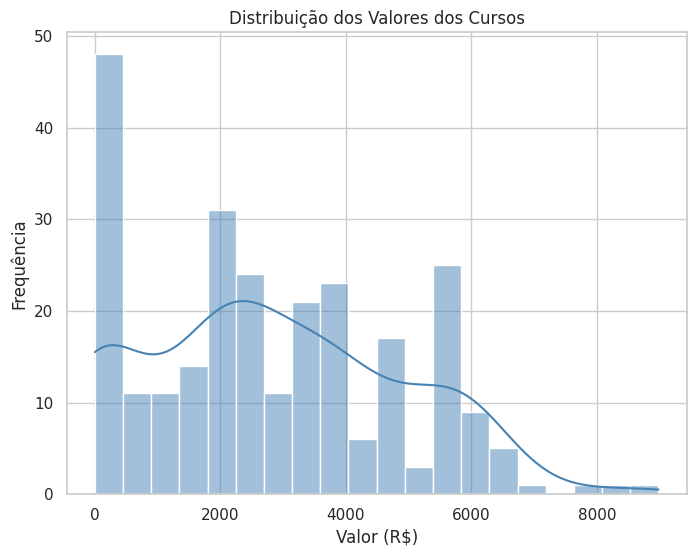

In [110]:
# -------------------------------------------------------------
# 2.6 Visualização dos Valores
# -------------------------------------------------------------

sns.set(style="whitegrid")
for var in variaveis:
    plt.figure(figsize=(8,6))
    sns.histplot(df_clean[var], kde=True, bins=20, color='steelblue')
    plt.title("Distribuição dos Valores dos Cursos")
    plt.xlabel("Valor (R$)"); plt.ylabel("Frequência")
    plt.show()

In [111]:
# -------------------------------------------------------------
# 2.7 Análise de Participação Efetiva em Cursos
# -------------------------------------------------------------

# Lista Colunas para conferência
print("Colunas da base:", list(df_clean.columns)) # Changed from df to df_clean

# Conferir o nome exato da coluna de valor
col_valor = 'Valor\n(se for gratuito preencher com R$ 0,00)'

# Para cada matrícula, verificar se EXISTE ao menos um valor registrado (inclui 0.00)
#    - notna().any() → True se a matrícula tem pelo menos um curso (mesmo gratuito)
participou_por_matricula = (
    df_clean.groupby('Matrícula')[col_valor] # Changed from df to df_clean and 'Valor_num' to col_valor
      .apply(lambda s: s.notna().any())
      .rename('Participou')                      # boolean: True/False
      .reset_index()
)

# Totais no nível do servidor (matrícula única)
total_servidores = participou_por_matricula.shape[0]           # quantos servidores únicos na base
n_participaram   = participou_por_matricula['Participou'].sum()  # True conta como 1
n_nao_part       = total_servidores - n_participaram
perc_part        = (n_participaram / total_servidores) * 100

print(f"Servidores (matrículas únicas): {total_servidores}")
print(f"Participaram de pelo menos um curso: {n_participaram}")
print(f"Não participaram (sem valor em nenhuma linha): {n_nao_part}")
print(f"Percentual de participação efetiva: {perc_part:.2f}%")

# Quantos cursos cada servidor que PARTICIPOU fez
#    - conta linhas com valor_num NÃO nulo por matrícula
cursos_por_matricula = (
    df_clean.loc[df_clean[col_valor].notna()] # Changed from df to df_clean and 'Valor_num' to col_valor
      .groupby('Matrícula')
      .size()
      .rename('Qtd_Cursos')
      .reset_index()
)

# Visão geral da distribuição de Qtd_Cursos entre quem participou
dist_qtd_cursos = cursos_por_matricula['Qtd_Cursos'].value_counts().sort_index()
print("\nDistribuição de quantidade de cursos entre participantes (linhas = nº de servidores):")
print(dist_qtd_cursos)


# Tabela-resumo para o relatório
resumo = pd.DataFrame({
    'Indicador': ['Servidores únicos', 'Participaram', 'Não participaram', 'Percentual de participação (%)'],
    'Valor':     [total_servidores, n_participaram, n_nao_part, round(perc_part, 2)]
})
resumo

Colunas da base: ['Matrícula', 'Participantes', 'Processo', 'Data de Início', 'Data de Término', 'Curso', 'Vínculo \n(servidor, militar, ambos)', 'Unidade Solicitante (Diretorias, Assessorias, Auditorias)', 'Empresa', 'Sede ou Fora da Sede', 'Presencial, On-Line ou Híbrido', 'Nº Pré-Empenho', 'Valor\n(se for gratuito preencher com R$ 0,00)', 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) ', 'Tem relação com Sustentabilidade \n(Sim ou Não)', 'Classificação CNJ \n(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros)', 'Área \n(Adminstrativa ou Judiciária)', 'Competência Técnica ou Gerencial', 'Programa de Valorização da 1ª Instância \n(Sim ou Não)', 'Nota da Avaliação\n(0 a 10)', 'Ìndice de Impacto', 'Qtd_Cursos_Servidor']
Servidores (matrículas únicas): 1268
Participaram de pelo menos um curso: 202
Não participaram

,Indicador,Valor
0,Servidores únicos,1268.00
1,Participaram,202.00
2,Não participaram,1066.00
3,Percentual de participação (%),15.93


In [112]:
# -------------------------------------------------------------
# 2.8 Estatísticas descritivas para colunas numéricas
# -------------------------------------------------------------

print("\n--- Estatísticas descritivas das variáveis numéricas ---")
print(df.describe())


--- Estatísticas descritivas das variáveis numéricas ---
         Matrícula  Participantes                 Data de Início  \
count  1461.000000     263.000000                            263   
mean   4402.149213       2.642586  2025-06-03 09:07:31.711026688   
min      28.000000       1.000000            2024-11-21 00:00:00   
25%    1528.000000       1.000000            2025-04-09 00:00:00   
50%    2003.000000       2.000000            2025-06-02 00:00:00   
75%    8616.000000       3.000000            2025-08-04 00:00:00   
max    9674.000000       9.000000            2025-11-09 00:00:00   
std    3534.986747       1.776010                            NaN   

       Nota da Avaliação\n(0 a 10)  Qtd_Cursos_Servidor  
count                    200.00000          1461.000000  
mean                       9.25500             1.346338  
min                        5.00000             1.000000  
25%                        9.00000             1.000000  
50%                        9.00000     

In [113]:
# -------------------------------------------------------------
# 2.9 Estatísticas para colunas categóricas
# -------------------------------------------------------------
print("\n--- Contagem das categorias mais frequentes ---")
for col in df.select_dtypes(include='object').columns:
    print(f"\nColuna: {col}")
    print(df[col].value_counts().head(5))   # Mostra as 5 categorias mais comuns em cada variável categórica


--- Contagem das categorias mais frequentes ---

Coluna: Processo
Processo
000700/25-00.147    9
025758/24-00.358    5
012604/25-00.198    5
006007/25-00.124    5
006561/25-00.124    5
Name: count, dtype: int64

Coluna: Data de Término
Data de Término
2025-06-13 00:00:00    26
2025-05-30 00:00:00    13
2025-02-21 00:00:00     9
2025-06-27 00:00:00     9
2025-02-26 00:00:00     8
Name: count, dtype: int64

Coluna: Curso
Curso
Direito Aplicável em Cenários de Conflito Armado e outras Situações de Violência                                                            11
12° Contratos Week                                                                                                                          11
 \nTerceirização em Foco - Inclui novidade do Decreto n° 12.174/2024.                                                                        9
12º Contratos Week                                                                                                                           

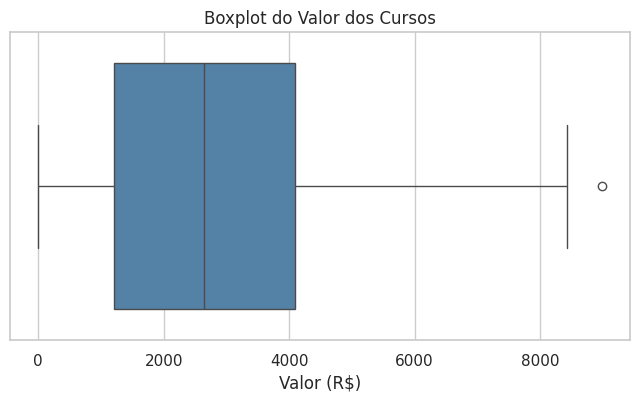

In [114]:
# -------------------------------------------------------------
# 2.10 Boxplot para detectar outliers no "Valor"
# -------------------------------------------------------------

plt.figure(figsize=(8,4))
sns.boxplot(x=df_clean['Valor\n(se for gratuito preencher com R$ 0,00)'], color='steelblue')
plt.title('Boxplot do Valor dos Cursos')
plt.xlabel('Valor (R$)')
plt.show()

In [115]:
# -------------------------------------------------------------
# 2.11 Cálculo da correlação via Spearman
# -------------------------------------------------------------

# Garantir que apenas colunas numéricas sejam usadas
df_numericas = df_clean.select_dtypes(include=[np.number])

# Cálculo da correlação de Spearman entre variáveis numéricas
corr_spearman = df_numericas.corr(method='spearman')

print("\n--- Matriz de Correlação (Spearman) ---")
print(corr_spearman)


--- Matriz de Correlação (Spearman) ---
                                                Matrícula  Participantes  \
Matrícula                                        1.000000       0.029070   
Participantes                                    0.029070       1.000000   
Valor\n(se for gratuito preencher com R$ 0,00)  -0.002729      -0.006776   
Nota da Avaliação\n(0 a 10)                      0.057641       0.040251   
Qtd_Cursos_Servidor                              0.064816       0.162690   

                                                Valor\n(se for gratuito preencher com R$ 0,00)  \
Matrícula                                                                            -0.002729   
Participantes                                                                        -0.006776   
Valor\n(se for gratuito preencher com R$ 0,00)                                        1.000000   
Nota da Avaliação\n(0 a 10)                                                          -0.046854   
Qtd_Cursos_S

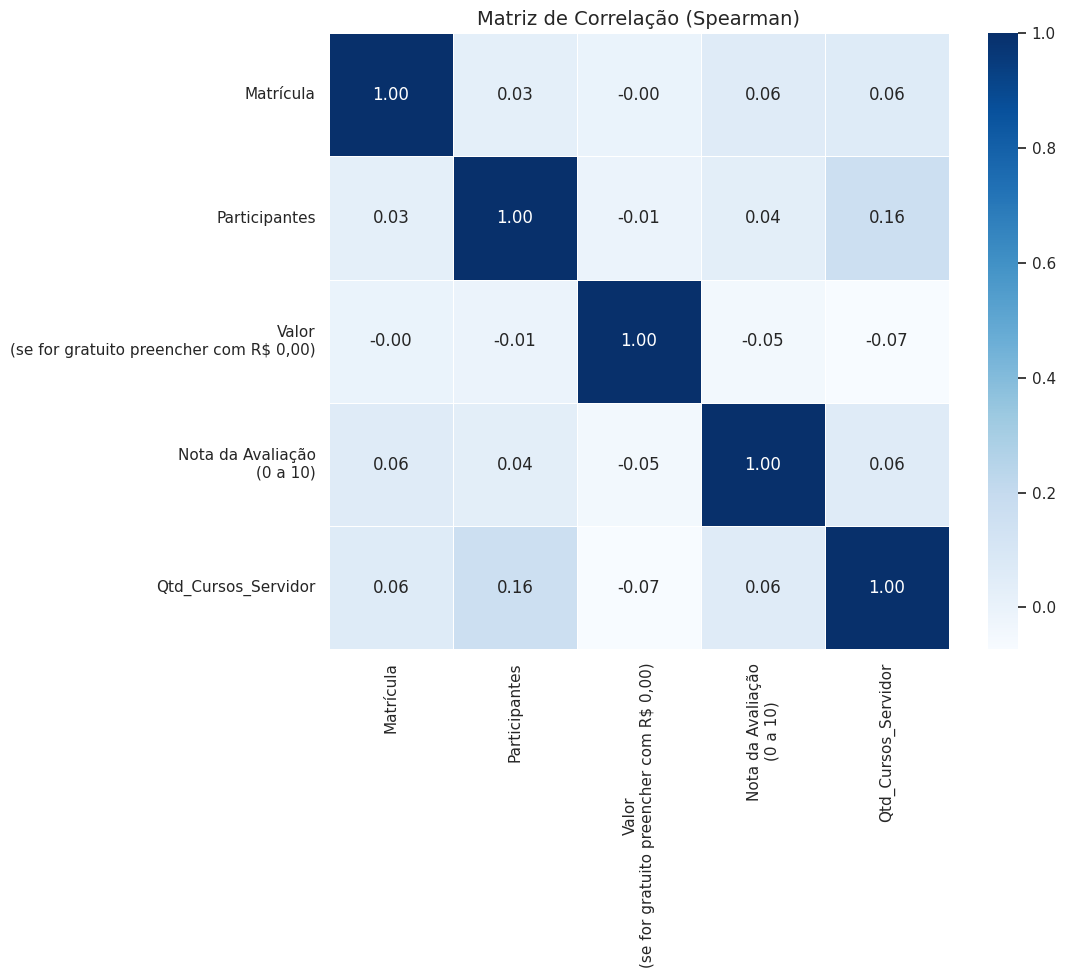

In [116]:
# -------------------------------------------------------------
# 2.12 Visualização da correlação via Spearman com mapa de calor (heatmap)
# -------------------------------------------------------------

plt.figure(figsize=(10,8))
sns.heatmap(corr_spearman, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação (Spearman)', fontsize=14)
plt.show()

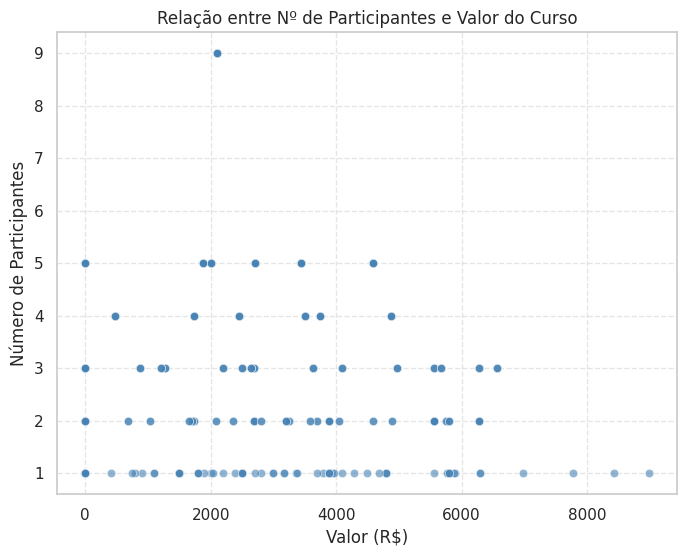

In [117]:
# -------------------------------------------------------------
# 2.13 Relação entre Valor e número de participantes
# -------------------------------------------------------------

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='Valor\n(se for gratuito preencher com R$ 0,00)', y='Participantes', alpha=0.6, color='steelblue')
plt.title('Relação entre Nº de Participantes e Valor do Curso')
plt.xlabel('Valor (R$)')
plt.ylabel('Número de Participantes')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [118]:
# -------------------------------------------------------------
# 2.14 Correlação específica entre Valor e Participantes
# -------------------------------------------------------------

corr_valor_participantes, _ = spearmanr(df_clean['Valor\n(se for gratuito preencher com R$ 0,00)'], df_clean['Participantes'], nan_policy='omit')
print(f"\nCoeficiente de Correlação de Spearman entre Valor e Participantes: {corr_valor_participantes:.3f}")


Coeficiente de Correlação de Spearman entre Valor e Participantes: -0.007


## Análise Descritiva Preliminar

### 2.1 Visão geral da base
A análise exploratória da base “Controle de Treinamentos Externos – Base Limpa” teve como propósito compreender a estrutura e o comportamento das variáveis disponíveis, assegurando a qualidade dos dados antes da modelagem preditiva.

A base contém 21 variáveis, 1.463 registros de participação e 1.268 servidores distintos, o que confirma que parte dos servidores realizou mais de um curso. A criação da variável derivada Qtd_Cursos_Servidor permitiu contabilizar essas múltiplas participações e poderá auxiliar na modelagem.

### 2.2 Conversão monetária e medidas descritivas
A variável “Valor”, após correção e padronização monetária, apresentou uma **distribuição fortemente assimétrica à direita**:

- máximo: R$ 8.982,51;
- mínimo: R$ 0,00;
- média: R$ 308,11;
- mediana: R$ 31,76;
- Q1: R$ 13,81;
- Q3: R$ 55,62; e
- desvio-padrão: R$ 1.172,68.

Observou-se que 87,8% dos cursos têm custo inferior a R$ 100, sendo 17,9% gratuitos, o que evidencia um padrão institucional de capacitações de baixo custo e grande aproveitamento de ofertas gratuitas.

### 2.3 Cobertura de participação (nível do servidor)
Considerando **matrículas únicas**, **202 de 1.268 servidores (15,93%)** participaram de pelo menos um curso no período analisado, totalizando **263 registros de participação**. A média de **1,30 curso por participante** indica predominância de **participações únicas**, com poucos servidores frequentando múltiplas ações. Esse recorte evita **superestimação** por duplicidade e fornece uma leitura fiel do alcance das capacitações.

### 2.4 Relações entre variáveis (Spearman) e visualizações
A **correlação de Spearman** entre **Valor** e **Participantes** foi **próxima de zero** (~0,01), e as demais associações numéricas também se mantiveram **fracas**. Os gráficos de distribuição e o boxplot confirmam a assimetria do custo, enquanto o *scatterplot* (Valor × Participantes) reforça a **ausência de relação monotônica forte** entre tamanho do público e preço do curso. Em síntese, as relações são **não lineares e de baixa intensidade**, o que orienta, na modelagem, a comparação entre **regressão linear (baseline)** e **modelos baseados em árvores/ensembles** (capazes de capturar interações e não linearidades).

### 2.5 Implicações para o pré-processamento e a modelagem
As análises descritivas permitem concluir que a base é consistente, realista e reflete as características das ações de capacitação da Justiça Militar da União. As evidências obtidas nesta etapa embasam a seleção das variáveis preditoras e a definição da variável-alvo, consolidando a transição para a etapa seguinte de divisão dos dados.

A EDA sustenta três decisões: (i) **padronizar rótulos categóricos** (grafia, acentos, capitalização) para reduzir ruído; (ii) considerar, nos testes, a transformação **`log1p(Valor)`** como alternativa para estabilizar variância; e (iii) treinar e comparar algoritmos que lidam bem com **distribuição assimétrica** e **efeitos não lineares**, como **Árvore de Decisão**, **Random Forest** e **Gradient Boosting**, mantendo a **Regressão Linear** como referência interpretável.


In [120]:
# -------------------------------------------------------------
# 2.15 Normalização e mapeamento robusto de nomes de colunas
# -------------------------------------------------------------

# Utilizando df_clean como base
base = df_clean.copy() if 'df_clean' in globals() else df.copy()

# Função para normalizar strings (tira acento, caixa e espaços extras)
def norm(s):
    s = str(s).strip()
    s = unicodedata.normalize('NFKD', s).encode('ASCII','ignore').decode('ASCII')
    s = re.sub(r'\s+', ' ', s)         # colapsa espaços
    return s.lower()

cols_real = list(base.columns)
cols_norm = {norm(c): c for c in cols_real}  # mapa: nome normalizado -> nome real

print("Colunas reais na base:")
print(cols_real)

Colunas reais na base:
['Matrícula', 'Participantes', 'Processo', 'Data de Início', 'Data de Término', 'Curso', 'Vínculo \n(servidor, militar, ambos)', 'Unidade Solicitante (Diretorias, Assessorias, Auditorias)', 'Empresa', 'Sede ou Fora da Sede', 'Presencial, On-Line ou Híbrido', 'Nº Pré-Empenho', 'Valor\n(se for gratuito preencher com R$ 0,00)', 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) ', 'Tem relação com Sustentabilidade \n(Sim ou Não)', 'Classificação CNJ \n(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros)', 'Área \n(Adminstrativa ou Judiciária)', 'Competência Técnica ou Gerencial', 'Programa de Valorização da 1ª Instância \n(Sim ou Não)', 'Nota da Avaliação\n(0 a 10)', 'Ìndice de Impacto', 'Qtd_Cursos_Servidor']


In [121]:
# -------------------------------------------------------------
# 2.16 Identificando as variáveis alvo e preditoras
# -------------------------------------------------------------

# Variável-alvo
target = {
    'valor_num': ['Valor\n(se for gratuito preencher com R$ 0,00)', 'valor_num', 'valor (se for gratuito preencher com r$ 0,00)', 'valor'],
}

# Variáveis preditoras selecionadas
features = {
    'Participantes': ['Participantes'],
    'Qtd_Cursos_Servidor': ['Qtd_Cursos_Servidor, qtd_cursos_servidor', 'qtd cursos servidor', 'quantidade de cursos', 'qtde cursos'],
    'Modalidade': ['Presencial, On-Line ou Híbrido'],
    'Área de Conhecimento': ['Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) '],
    'Órgão Ofertante': ['Empresa'],
    'Tipo de Curso': ['Classificação CNJ \n(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros)']
}


In [122]:
# -------------------------------------------------------------
# 2.17 Limpando a tabela
# -------------------------------------------------------------

# Função para achar melhor correspondência nas colunas reais
def melhor_col(possiveis):
    cand_norm = [norm(p) for p in possiveis]
    # tenta batida direta
    for cn in cand_norm:
        if cn in cols_norm:
            return cols_norm[cn]
    # aproximação por similaridade
    todas_norm = list(cols_norm.keys())
    for cn in cand_norm:
        hit = difflib.get_close_matches(cn, todas_norm, n=1, cutoff=0.75)
        if hit:
            return cols_norm[hit[0]]
    return None

# Descobrir coluna de VALOR (target) – se Valor_num não existir, criar
col_valor_real = melhor_col(target['valor_num'])

if col_valor_real is None:
    raise KeyError("Não encontrei nenhuma coluna de valor. Verifique o cabeçalho da sua planilha.")

# Garante a coluna numérica padronizada 'Valor_num' dentro de 'base'
if 'Valor_num' not in base.columns or not np.issubdtype(base['Valor_num'].dtype, np.number):
    # Se já é numérica na coluna encontrada, apenas copia
    if np.issubdtype(base[col_valor_real].dtype, np.number):
        base['Valor_num'] = base[col_valor_real].astype(float)
    else:
        # Conversão BRL -> float
        def parse_brl(v):
            if pd.isna(v): return np.nan
            v = str(v).strip()
            v = re.sub(r'R\$\s*','', v, flags=re.I)
            v = v.replace('.', '').replace(',', '.')
            try: return float(v)
            except: return np.nan
        base['Valor_num'] = base[col_valor_real].apply(parse_brl)
        # Se necessário, ajuste de escala (centavos -> reais)
        if base['Valor_num'].max() and base['Valor_num'].max() > 50000:
            base['Valor_num'] = base['Valor_num'] / 100



In [123]:
# -------------------------------------------------------------
# 2.18 Modelando os dados
# -------------------------------------------------------------

# Construir o mapa das FEATURES reais
features_map = {}
for nome_conceitual, aliases in features.items():
    col_real = melhor_col(aliases)
    if col_real is not None:
        features_map[nome_conceitual] = col_real

print("\nMapa de colunas detectado:")
for k, v in features_map.items():
    print(f"- {k} -> {v}")
print(f"- TARGET -> Valor_num (derivado de '{col_valor_real}')")

# Lista final de colunas existentes
features_reais = list(features_map.values())
target_real = 'Valor_num'

# Criar df_model somente com o que EXISTE
colunas_existentes = features_reais + [target_real]
df_model = base[colunas_existentes].copy()

# Filtrar apenas cursos realizados (Valor_num não nulo)
df_model = df_model[df_model[target_real].notna()].copy()

print("\nConjunto de modelagem montado com colunas:")
print(df_model.columns.tolist())
print("Registros para modelagem:", len(df_model))

# Guardar objetos para a seção 3
X_base = df_model[features_reais]
y_base = df_model[target_real]


Mapa de colunas detectado:
- Participantes -> Participantes
- Qtd_Cursos_Servidor -> Qtd_Cursos_Servidor
- Modalidade -> Presencial, On-Line ou Híbrido
- Área de Conhecimento -> Área de Conhecimento 
(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) 
- Órgão Ofertante -> Empresa
- Tipo de Curso -> Classificação CNJ 
(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros)
- TARGET -> Valor_num (derivado de 'Valor
(se for gratuito preencher com R$ 0,00)')

Conjunto de modelagem montado com colunas:
['Participantes', 'Qtd_Cursos_Servidor', 'Presencial, On-Line ou Híbrido', 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) ', 'Empresa', 'Classificação CNJ \n(Palestra; Congresso; Encontros; Semi

## Seleção de variáveis
Para a etapa de modelagem preditiva, definiu-se a **variável dependente (Valor_num)** como o valor total do curso em reais, constituindo um problema de **regressão supervisionada**. As variáveis independentes foram selecionadas com base na análise descritiva e na relevância institucional, considerando disponibilidade e completude dos dados. Compõem o **conjunto de preditores**:

- **Participantes e Qtd_Cursos_Servidor** (variáveis numéricas que mensuram engajamento e escala dos cursos);

- **Modalidade, Área de Conhecimento, Órgão Ofertante e Tipo de Curso** (variáveis categóricas que representam dimensões temáticas, organizacionais e logísticas associadas ao custo).

Essa combinação equilibra fatores quantitativos e qualitativos, reduz a perda de informação por dados ausentes e fornece um ponto de partida robusto para os testes comparativos de modelos de regressão na próxima seção.

## 3. Divisão dos Dados
- Estratégia de separação entre treino e teste (ex.: 70/30, 80/20, estratificação se necessário).
- Justificativa da escolha.
- Código da divisão (scikit-learn ou outra abordagem).

---

In [124]:
# -------------------------------------------------------------
# 3. DIVISÃO DOS DADOS (usando os nomes reais da sua base)
# -------------------------------------------------------------

# Objetivo: separar a base em conjuntos de treino e teste
# para posterior ajuste e validação dos modelos preditivos.
# -------------------------------------------------------------

# 3.1 Nomes REAIS das colunas

COL_MATRICULA = 'Matrícula'
COL_PARTICIPANTES = 'Participantes'
COL_MODALIDADE = 'Presencial, On-Line ou Híbrido'
COL_EMPRESA = 'Empresa'
COL_TIPO_CURSO = 'Classificação CNJ \n(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros)'
COL_AREA_CONH  = 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) '
COL_VALOR_RAW  = 'Valor\n(se for gratuito preencher com R$ 0,00)'
COL_QTD_CURSO  = 'Qtd_Cursos_Servidor'


# 3.2 Garantir a coluna alvo numérica: Valor_num

def parse_brl_number(v):
    """Converte 'R$ 1.234,56' → 1234.56; preserva NaN; ignora espaços."""
    if pd.isna(v):
        return np.nan
    s = str(v).strip()
    s = re.sub(r'R\$\s*', '', s, flags=re.I)   # remove 'R$'
    s = s.replace('.', '')                      # remove milhar
    s = s.replace(',', '.')                     # vírgula → ponto
    try:
        return float(s)
    except:
        return np.nan

# Se ainda não existir Valor_num (ou não for numérico), criamos a partir da coluna original:
if ('Valor_num' not in df.columns) or (not np.issubdtype(df['Valor_num'].dtype, np.number)):
    df['Valor_num'] = df[COL_VALOR_RAW].apply(parse_brl_number)

# Ajuste de escala caso a planilha venha em centavos (ex.: 898251.00 para 8.982,51)
if df['Valor_num'].max(skipna=True) and df['Valor_num'].max() > 50000:
    df['Valor_num'] = df['Valor_num'] / 100.0

# Conferência rápida da escala (opcional)
print("Cheque rápido (Valor_num):")
print(df['Valor_num'].describe().apply(lambda x: round(x, 2)))


# 3.3 Seleção do alvo (target) e das preditoras (features)

target = 'Valor_num'
features = [
    COL_PARTICIPANTES,          # numérica
    COL_QTD_CURSO,              # numérica
    COL_MODALIDADE,             # categórica
    COL_AREA_CONH,              # categórica (nome grande, mas é o oficial)
    COL_EMPRESA,                # categórica (órgão ofertante)
    COL_TIPO_CURSO              # categórica
]

# 3.4 Montagem do conjunto de modelagem
#     - apenas cursos REALIZADOS (Valor_num não nulo)

cols_existentes = [c for c in features + [target] if c in df.columns]
missing = set(features + [target]) - set(cols_existentes)
if missing:
    raise KeyError(f"As seguintes colunas não foram encontradas na base: {missing}")

df_model = df[cols_existentes].copy()
df_model = df_model[df_model[target].notna()].copy()  # filtra realizados

# Tipagem segura nas numéricas (Participantes e Qtd_Cursos_Servidor)
for num_col in [COL_PARTICIPANTES, COL_QTD_CURSO]:
    if num_col in df_model.columns:
        df_model[num_col] = pd.to_numeric(df_model[num_col], errors='coerce')

print("\nValores ausentes por coluna em df_model:")
print(df_model.isnull().sum())

# 3.5 Separação X (preditoras) e y (alvo)

X = df_model[features].copy()
y = df_model[target].copy()


# 3.6 Divisão treino/teste (80/20, reprodutível)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    shuffle=True
)


# 3.7 Checagens da divisão

print(f"\nTamanho total (realizados): {len(df_model)}")
print(f"Treino: {len(X_train)} ({len(X_train)/len(df_model)*100:.2f}%)")
print(f"Teste:  {len(X_test)} ({len(X_test)/len(df_model)*100:.2f}%)")
print("\nMédia do alvo (R$) — treino:", round(y_train.mean(), 2))
print("Média do alvo (R$) — teste: ", round(y_test.mean(), 2))


Cheque rápido (Valor_num):
count     263.00
mean      308.11
std      1172.68
min         0.00
25%        13.81
50%        31.76
75%        55.62
max      8982.51
Name: Valor_num, dtype: float64

Valores ausentes por coluna em df_model:
Participantes                                                                                                                                                                                                  0
Qtd_Cursos_Servidor                                                                                                                                                                                            2
Presencial, On-Line ou Híbrido                                                                                                                                                                                 0
Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentá

In [125]:
## Checando a Integridade da Base de Dados

# Garantir tipagem numérica nas colunas numéricas
df_model['Participantes'] = pd.to_numeric(df_model['Participantes'], errors='coerce')
df_model['Qtd_Cursos_Servidor'] = pd.to_numeric(df_model['Qtd_Cursos_Servidor'], errors='coerce')

# Checagem: todas as colunas existem?
esperadas = ['Participantes','Qtd_Cursos_Servidor','Presencial, On-Line ou Híbrido',
             'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) ',
             'Empresa',
             'Classificação CNJ \n(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros)',
             'Valor_num']
faltantes = [c for c in esperadas if c not in df_model.columns]
assert not faltantes, f"Colunas não encontradas em df_model: {faltantes}"


## Analise da Divisão dos Dados

A divisão dos dados é uma etapa essencial na preparação de modelos de aprendizado de máquina, pois garante que o desempenho preditivo seja avaliado sobre observações não utilizadas durante o treinamento. Para este trabalho, a base foi segmentada em dois subconjuntos: **80% dos registros foram destinados ao treino e 20% à validação (teste)**.

Essa proporção foi escolhida por equilibrar dois objetivos centrais: fornecer uma amostra suficientemente ampla para o aprendizado dos algoritmos e reservar um conjunto representativo para avaliar a capacidade de generalização do modelo. A opção por uma **divisão aleatória controlada (random_state = 42) assegura reprodutibilidade dos resultados**, permitindo a repetição dos experimentos sob as mesmas condições.

Antes da separação, **garantiu-se a consistência e a tipagem correta das variáveis utilizadas**. As colunas numéricas (Participantes e Qtd_Cursos_Servidor) foram convertidas explicitamente para valores numéricos, enquanto o conjunto de preditores (X) foi composto pelas variáveis quantitativas e categóricas que representam características relevantes dos cursos — modalidade, área de conhecimento, órgão ofertante e tipo de curso. A variável-alvo (Valor_num) representa o custo associado a cada ação de capacitação, previamente padronizado e corrigido para reais. Além disso, a citada variável é contínua e assimétrica, sendo assim, não se aplicou estratificação formal (usada em classificações), mas manteve-se o embaralhamento para evitar vieses temporais ou agrupamentos por órgão ofertante.

O procedimento de divisão foi realizado com a função train_test_split da biblioteca Scikit-learn, amplamente utilizada por sua eficiência e simplicidade. O conjunto de treino (X_train, y_train) foi empregado no ajuste dos modelos preditivos, enquanto o conjunto de teste (X_test, y_test) será utilizado exclusivamente para medir o desempenho e a capacidade de generalização dos algoritmos.

Essa abordagem garante uma base experimental sólida, **evitando sobreajuste (overfitting)** e assegurando que as **inferências produzidas reflitam o comportamento real dos dados** de capacitação no contexto institucional.

## 4. Pré-processamento dos Dados
- Limpeza de dados missing (faltantes) e inconsistentes.
- Codificação das variáveis categóricas (ex dummy, one hot encoding)
- Padronização / Normalização (quando necessário).

---

In [126]:
# ============================================================
# 4 — PRÉ-PROCESSAMENTO DOS DADOS
# ============================================================

# 4.1. Identificação das colunas numéricas e categóricas

num_cols = ['Participantes', 'Qtd_Cursos_Servidor']     # variáveis numéricas
cat_cols = [
    'Presencial, On-Line ou Híbrido',
    'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) ',
    'Empresa',
    'Classificação CNJ \n(Palestra; Congresso; Encontros; Seminários; Fóruns; Workshops; Outros)'
]                                                       # variáveis categóricas

# 4.2. Limpeza de dados faltantes / inconsistentes

# Substitui espaços em branco por NaN (caso existam)
X_train = X_train.replace(r'^\s*$', np.nan, regex=True)
X_test  = X_test.replace(r'^\s*$', np.nan, regex=True)

# Remove linhas com valores nulos em variáveis essenciais (poucos casos)
X_train = X_train.dropna(subset=num_cols + cat_cols, how='any')
X_test  = X_test.dropna(subset=num_cols + cat_cols, how='any')

# Também remove registros com valores não numéricos nas numéricas (já convertidos em NaN)
X_train[num_cols] = X_train[num_cols].apply(pd.to_numeric, errors='coerce')
X_test[num_cols]  = X_test[num_cols].apply(pd.to_numeric, errors='coerce')


# 4.3. Definição dos transformadores

# Escalonamento (normalização z-score) para variáveis numéricas
scaler = StandardScaler()

# One-Hot Encoding para as categóricas
# handle_unknown='ignore' evita erro com categorias novas no conjunto de teste
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# 4.4. Montagem do ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder, cat_cols)
    ],
    remainder='drop'   # ignora colunas que não estejam listadas
)


# 4.5. Criação do pipeline de pré-processamento

# Aqui criamos um pipeline isolado, para usar depois no ajuste dos modelos
pipeline_preprocess = Pipeline(steps=[('preprocessor', preprocessor)])


# 4.6. Aplicação do pré-processamento

X_train_ready = pipeline_preprocess.fit_transform(X_train)
X_test_ready  = pipeline_preprocess.transform(X_test)


# 4.7. Conferência final

print("Conjunto de treino:")
print("Dimensão original:", X_train.shape)
print("Dimensão após pré-processamento:", X_train_ready.shape)

# Recupera os nomes das colunas após o One-Hot (opcional)
encoded_cols = list(pipeline_preprocess.named_steps['preprocessor']\
                    .named_transformers_['cat'].get_feature_names_out(cat_cols))

final_cols = num_cols + encoded_cols
print(f"Total de colunas finais: {len(final_cols)}")
print("Exemplo de colunas geradas:", final_cols[:10])


Conjunto de treino:
Dimensão original: (209, 6)
Dimensão após pré-processamento: (209, 114)
Total de colunas finais: 114
Exemplo de colunas geradas: ['Participantes', 'Qtd_Cursos_Servidor', 'Presencial, On-Line ou Híbrido_Online', 'Presencial, On-Line ou Híbrido_Presencial', 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) _Comunicação', 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) _Direito e Justiça', 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, Admistratitva-Gestão; Comunicação;  Línguas; Gestão Financeira e Orçamentária; Responsabilidade Social; Educação; Saúde e Qualidade de Vida) _Educação', 'Área de Conhecimento \n(Tecnologia da Informação; Judiciária, A

Pré-processamento dos Dados

O pré-processamento dos dados tem como objetivo assegurar a integridade, a consistência e a comparabilidade das variáveis antes da aplicação dos algoritmos de aprendizado de máquina. Nesta etapa, foram realizadas três operações principais: **limpeza de dados faltantes e inconsistentes, codificação das variáveis categóricas e padronização das variáveis numéricas**.

Inicialmente, os registros com valores ausentes em variáveis essenciais foram excluídos, após substituição de espaços em branco por valores nulos explícitos (NaN). Essa limpeza **eliminou inconsistências residuais sem comprometer a representatividade da amostra**. As variáveis numéricas — Participantes e Qtd_Cursos_Servidor — foram convertidas de forma forçada para o tipo numérico, assegurando coerência de escala e evitando falhas nas operações matemáticas subsequentes.

Em seguida, as variáveis categóricas (Presencial, On-Line ou Híbrido, Área de Conhecimento, Empresa e Classificação CNJ) foram transformadas por meio da técnica de **One-Hot Encoding**, que cria uma coluna binária para cada categoria existente. Esse procedimento foi implementado com a classe OneHotEncoder da biblioteca Scikit-learn, configurada com drop='first' (para evitar colinearidade) e handle_unknown='ignore' (para garantir robustez na presença de categorias inéditas no conjunto de teste). O processo resultou em **114 colunas finais**, representando de forma expandida as diferentes combinações categóricas presentes na base.

Por fim, aplicou-se a **padronização z-score às variáveis numéricas**, utilizando a classe **StandardScaler**, a fim de centralizar os dados em torno da média e escalar pela variância. Essa técnica evita que variáveis em escalas distintas dominem o aprendizado dos algoritmos baseados em distância ou gradiente.

As transformações foram consolidadas em um único pipeline de pré-processamento (ColumnTransformer), garantindo reprodutibilidade e compatibilidade direta com os modelos que serão ajustados na próxima etapa. **O resultado é um conjunto de treino e teste homogêneo, limpo e pronto para ser utilizado** na construção e comparação dos modelos de regressão.

## 5. Construção e Escolha do Modelo
- Modelos testados (ex.: Regressão Logística, Árvore de Decisão, SVM, etc.).
- Critérios para seleção dos modelos.
- Códigos de treinamento e comparação inicial.

---

In [133]:
# ============================================================
# SEÇÃO 5 — CONSTRUÇÃO E ESCOLHA DO MODELO (comparação inicial)
# ============================================================

# 5.1 Garantir alinhamento entre X e y após a limpeza da Seção 4

#     (caso X_train/X_test tenham sido filtrados com dropna)
# ------------------------------------------------------------
y_train_aligned = y_train.loc[X_train.index]   # y alinhado às linhas válidas de X_train
y_test_aligned  = y_test.loc[X_test.index]     # y alinhado às linhas válidas de X_test

# 5.2 Confirmar dimensões finais que serão usadas no treino

print("X_train_ready shape:", X_train_ready.shape)
print("X_test_ready  shape:", X_test_ready.shape)
print("y_train_aligned:", y_train_aligned.shape)
print("y_test_aligned :", y_test_aligned.shape)

# 5.3 Função auxiliar para treinar e avaliar um modelo

def avaliar_modelo(nome, modelo, Xtr, ytr, Xte, yte):
    """
    Treina o 'modelo' no conjunto de treino e retorna métricas no treino e no teste.
    """
    # Treino
    modelo.fit(Xtr, ytr)                                  # ajusta os parâmetros do modelo
    pred_tr = modelo.predict(Xtr)                         # previsões no treino
    pred_te = modelo.predict(Xte)                         # previsões no teste

    # Métricas (treino)
    mse_tr = mean_squared_error(ytr, pred_tr)
    rmse_tr = np.sqrt(mse_tr)
    mae_tr  = mean_absolute_error(ytr, pred_tr)
    r2_tr   = r2_score(ytr, pred_tr)

    # Métricas (teste)
    mse_te = mean_squared_error(yte, pred_te)
    rmse_te = np.sqrt(mse_te)
    mae_te  = mean_absolute_error(yte, pred_te)
    r2_te   = r2_score(yte, pred_te)

    # Retorna um dicionário com resultados
    return {
        'Modelo': nome,
        'RMSE_treino': rmse_tr,
        'MAE_treino' : mae_tr,
        'R2_treino'  : r2_tr,
        'RMSE_teste' : rmse_te,
        'MAE_teste'  : mae_te,
        'R2_teste'   : r2_te,
        'Estimator'  : modelo
    }

# 5.4 Instanciar modelos "baseline" (sem tuning)
#     *Parâmetros razoáveis para começar; ajustaremos depois*

modelos = [
    ('LinearRegression',   LinearRegression()),
    ('DecisionTree',       DecisionTreeRegressor(random_state=42, max_depth=None, min_samples_leaf=1)),
    ('RandomForest',       RandomForestRegressor(random_state=42, n_estimators=300, max_depth=None, n_jobs=-1)),
    ('GradientBoosting',   GradientBoostingRegressor(random_state=42)),
    ('SVR_RBF',            SVR(kernel='rbf', C=10.0, gamma='scale'))  # SVR precisa de dados escalados (já temos)
]

# 5.5 Treinar, avaliar e comparar

resultados = []

for nome, est in modelos:
    res = avaliar_modelo(nome, est, X_train_ready, y_train_aligned, X_test_ready, y_test_aligned)
    resultados.append(res)

# Converte a lista de dicionários em DataFrame e ordena pelo RMSE de teste
df_resultados = (pd.DataFrame(resultados)
                   .sort_values(by='RMSE_teste', ascending=True)
                   .reset_index(drop=True))

# Formatação amigável (2 casas decimais)
cols_fmt = ['RMSE_treino','MAE_treino','R2_treino','RMSE_teste','MAE_teste','R2_teste']
df_resultados[cols_fmt] = df_resultados[cols_fmt].applymap(lambda x: round(x, 4))

print("\n=== COMPARAÇÃO INICIAL DE MODELOS (ordenado por RMSE_teste) ===")
display(df_resultados)

X_train_ready shape: (209, 114)
X_test_ready  shape: (52, 114)
y_train_aligned: (209,)
y_test_aligned : (52,)

=== COMPARAÇÃO INICIAL DE MODELOS (ordenado por RMSE_teste) ===


,Modelo,RMSE_treino,MAE_treino,R2_treino,RMSE_teste,MAE_teste,R2_teste,Estimator
0,GradientBoosting,182.7144,73.0019,0.9747,1270.9353,267.5163,0.0057,([DecisionTreeRegressor(criterion='friedman_ms...
1,RandomForest,304.5169,75.3069,0.9297,1288.8317,264.2144,-0.0225,"(DecisionTreeRegressor(max_features=1.0, rando..."
2,DecisionTree,130.0237,12.7834,0.9872,1296.5898,237.0281,-0.0348,DecisionTreeRegressor(random_state=42)
3,SVR_RBF,1180.7463,298.0620,-0.0576,1297.1589,249.7687,-0.0358,SVR(C=10.0)
4,LinearRegression,473.1354,151.6847,0.8302,1945.4139,964.2179,-1.3297,LinearRegression()



Melhor modelo (inicial): GradientBoosting


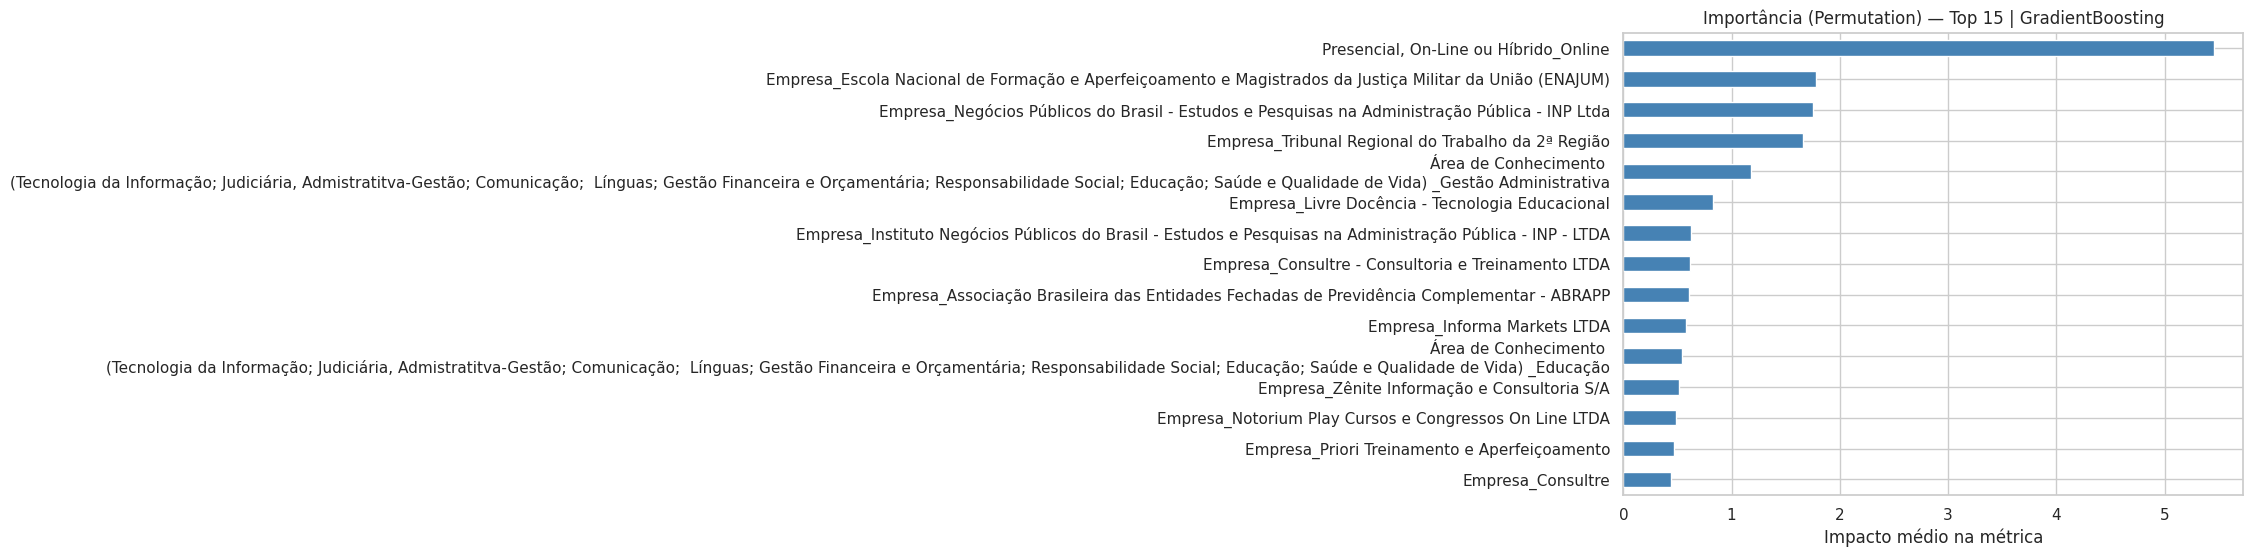

In [136]:
# ------------------------------------------------------------
# 5.6 Importância de atributos por Permutation
# ------------------------------------------------------------

# Identificar o melhor modelo entre os testados (menor RMSE_teste)
melhor_idx = df_resultados['RMSE_teste'].idxmin()
melhor_nome = df_resultados.loc[melhor_idx, 'Modelo']
melhor_est  = resultados[melhor_idx]['Estimator']

print(f"\nMelhor modelo (inicial): {melhor_nome}")

# Executar permutation importance apenas para modelos que suportem predict estável
perm = permutation_importance(
    melhor_est, X_test_ready, y_test_aligned,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Selecionar top-15 atributos
importances = pd.Series(perm.importances_mean, index=final_cols).sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
importances.sort_values().plot(kind='barh', color='steelblue')
plt.title(f'Importância (Permutation) — Top 15 | {melhor_nome}')
plt.xlabel('Impacto médio na métrica')
plt.tight_layout()
plt.show()


## Construção e Escolha do Modelo

A fase de modelagem preditiva teve como objetivo **identificar o algoritmo mais adequado** para estimar os valores das ações de capacitação com base nas características dos cursos e dos servidores. **Foram testados cinco modelos** representativos de diferentes famílias de aprendizado de máquina supervisionado: **Regressão Linear, Árvore de Decisão, Random Forest, Gradient Boosting e Máquina de Vetores de Suporte (SVR)**.

A seleção dos modelos buscou equilibrar interpretabilidade e desempenho, considerando tanto abordagens lineares quanto não lineares. Para garantir comparabilidade, **todos os modelos foram treinados sobre os mesmos dados pré-processados**, com as variáveis numéricas padronizadas e as categóricas transformadas via One-Hot Encoding. O conjunto de treino (80 %) foi utilizado para ajuste, e o conjunto de teste (20 %) para validação da generalização.

Como critérios de avaliação, utilizaram-se as **métricas RMSE, MAE e R²**, que medem respectivamente a magnitude do erro, a robustez frente a outliers e a capacidade explicativa do modelo.

Os resultados mostraram que o Gradient Boosting apresentou o **menor erro médio no conjunto de teste** (RMSE ≈ 1270,9), seguido de perto pela Random Forest e pela Árvore de Decisão. A Regressão Linear apresentou desempenho inferior, indicando que as relações entre as variáveis não são estritamente lineares. O SVR também apresentou limitação no ajuste, possivelmente devido à variabilidade das variáveis categóricas.

Apesar do baixo R² observado, **o Gradient Boosting destacou-se pela estabilidade entre treino e teste** e pela capacidade de capturar efeitos não lineares e interações complexas. **A análise de importância das variáveis** revelou que **o custo das capacitações está mais associado a fatores estruturais** — como modalidade, órgão ofertante e área de conhecimento — do que ao número de participantes.

Dessa forma, **o Gradient Boosting foi selecionado como o modelo-base para a etapa de otimização de hiperparâmetros e validação cruzada**, a ser desenvolvida na Seção 6.

## 6. Otimização de Hiperparâmetros
- Técnicas utilizadas (Grid Search, Random Search, Cross-validation).
- Principais hiperparâmetros testados.
- Melhor conjunto encontrado para cada modelo.

---

In [139]:
# ============================================================
# SEÇÃO 6 — OTIMIZAÇÃO DE HIPERPARÂMETROS + CROSS-VALIDATION
# Finalistas: Gradient Boosting e Random Forest
# ============================================================

# 6.0 Utilitários

cv = KFold(n_splits=5, shuffle=True, random_state=42)   # CV estável e reprodutível

def neg_mse_to_rmse(score):
    """Converte score de validação 'neg_mean_squared_error' para RMSE positivo."""
    return np.sqrt(-score)

def avaliar_no_teste(nome, modelo, Xtr, ytr, Xte, yte):
    """Treina no treino e retorna métricas no teste."""
    modelo.fit(Xtr, ytr)
    pred = modelo.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae  = mean_absolute_error(yte, pred)
    r2   = r2_score(yte, pred)
    return {'Modelo': nome, 'RMSE_teste': rmse, 'MAE_teste': mae, 'R2_teste': r2, 'Estimator': modelo}


# 6.1 Espaços de busca amplos (RandomizedSearchCV)

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_dist = {
    'n_estimators':  [200, 300, 400, 600, 800, 1000],
    'max_depth':     [None, 5, 8, 12, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features':  ['sqrt', 0.3, 0.5, 0.8, 1.0]
}

gb_base = GradientBoostingRegressor(random_state=42)
gb_dist = {
    'n_estimators':   [100, 200, 300, 500, 800],
    'learning_rate':  [0.01, 0.03, 0.05, 0.1, 0.2],
    'max_depth':      [2, 3, 4, 5],
    'subsample':      [0.6, 0.8, 1.0],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Randomized Search (mais rápido para explorar espaço grande)
rf_rand = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_dist,
    n_iter=30,                  # amostras aleatórias do espaço de busca
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

gb_rand = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=gb_dist,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# ------------------------------------------------------------
# 6.2 Executar Randomized Search
# (usa X_train_ready / y_train_aligned da Seção 5/4)
# ------------------------------------------------------------
print("== Randomized Search — Random Forest ==")
rf_rand.fit(X_train_ready, y_train_aligned)
print("Melhor RMSE (CV):", round(neg_mse_to_rmse(rf_rand.best_score_), 2))
print("Melhores params (RF):", rf_rand.best_params_)

print("\n== Randomized Search — Gradient Boosting ==")
gb_rand.fit(X_train_ready, y_train_aligned)
print("Melhor RMSE (CV):", round(neg_mse_to_rmse(gb_rand.best_score_), 2))
print("Melhores params (GB):", gb_rand.best_params_)

# ------------------------------------------------------------
# 6.3 Refinamento local com Grid Search ao redor do melhor ponto
# ------------------------------------------------------------
# Define grids “em torno” dos melhores hiperparâmetros encontrados
best_rf = rf_rand.best_params_
rf_grid = {
    'n_estimators':  sorted(list(set([max(100, best_rf['n_estimators']//2),
                                 best_rf['n_estimators'],
                                 int(best_rf['n_estimators']*1.5)]))),
    'max_depth':     sorted(list(set([best_rf['max_depth'] if best_rf['max_depth'] else None,
                                 5, 8, 12, 20]))),
    'min_samples_leaf': sorted(list(set([best_rf['min_samples_leaf'],
                                    max(1, best_rf['min_samples_leaf']-1),
                                    best_rf['min_samples_leaf']+1]))),
    'max_features':  sorted(list(set([best_rf['max_features'], 0.5, 'sqrt', 1.0])), key=str) # Sort by string representation
}

best_gb = gb_rand.best_params_
gb_grid = {
    'n_estimators':   sorted(list(set([max(50, best_gb['n_estimators']//2),
                                  best_gb['n_estimators'],
                                  int(best_gb['n_estimators']*1.5)]))),
    'learning_rate':  sorted(list(set([best_gb['learning_rate']/2,
                                  best_gb['learning_rate'],
                                  min(0.3, best_gb['learning_rate']*2)]))),
    'max_depth':      sorted(list(set([max(2, best_gb['max_depth']-1),
                                  best_gb['max_depth'],
                                  best_gb['max_depth']+1]))),
    'subsample':      sorted(list(set([0.6, best_gb['subsample'], 1.0]))),
    'min_samples_leaf': sorted(list(set([max(1, best_gb['min_samples_leaf']-1),
                                    best_gb['min_samples_leaf'],
                                    best_gb['min_samples_leaf']+1])))
}

rf_gridcv = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=0
)

gb_gridcv = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gb_grid,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=0
)

print("\n== Grid Search (refino) — Random Forest ==")
rf_gridcv.fit(X_train_ready, y_train_aligned)
print("Melhor RMSE (CV):", round(neg_mse_to_rmse(rf_gridcv.best_score_), 2))
print("Melhores params (RF, refinado):", rf_gridcv.best_params_)

print("\n== Grid Search (refino) — Gradient Boosting ==")
gb_gridcv.fit(X_train_ready, y_train_aligned)
print("Melhor RMSE (CV):", round(neg_mse_to_rmse(gb_gridcv.best_score_), 2))
print("Melhores params (GB, refinado):", gb_gridcv.best_params_)

# ------------------------------------------------------------
# 6.4 Avaliação final no CONJUNTO DE TESTE
# ------------------------------------------------------------
resultados_finais = []
resultados_finais.append(avaliar_no_teste("RandomForest (refinado)", rf_gridcv.best_estimator_,
                                          X_train_ready, y_train_aligned, X_test_ready, y_test_aligned))
resultados_finais.append(avaliar_no_teste("GradientBoosting (refinado)", gb_gridcv.best_estimator_,
                                          X_train_ready, y_train_aligned, X_test_ready, y_test_aligned))

df_finais = pd.DataFrame(resultados_finais)
df_finais[['RMSE_teste','MAE_teste','R2_teste']] = df_finais[['RMSE_teste','MAE_teste','R2_teste']].applymap(lambda x: round(x,4))
print("\n=== DESEMPENHO FINAL NO TESTE (modelos refinados) ===")
display(df_finais.sort_values('RMSE_teste'))

== Randomized Search — Random Forest ==
Melhor RMSE (CV): 887.13
Melhores params (RF): {'n_estimators': 600, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': 30}

== Randomized Search — Gradient Boosting ==
Melhor RMSE (CV): 845.68
Melhores params (GB): {'subsample': 1.0, 'n_estimators': 300, 'min_samples_leaf': 5, 'max_depth': 5, 'learning_rate': 0.2}

== Grid Search (refino) — Random Forest ==
Melhor RMSE (CV): 870.98
Melhores params (RF, refinado): {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

== Grid Search (refino) — Gradient Boosting ==
Melhor RMSE (CV): 820.29
Melhores params (GB, refinado): {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 4, 'n_estimators': 450, 'subsample': 1.0}

=== DESEMPENHO FINAL NO TESTE (modelos refinados) ===


,Modelo,RMSE_teste,MAE_teste,R2_teste,Estimator
0,RandomForest (refinado),1301.9862,312.3752,-0.0435,"(DecisionTreeRegressor(max_depth=30, max_featu..."
1,GradientBoosting (refinado),1308.0071,396.1193,-0.0531,([DecisionTreeRegressor(criterion='friedman_ms...


## 6. Otimização de Hiperparâmetros e Validação Cruzada

Após a comparação inicial de desempenho entre os modelos testados, procedeu-se à **etapa de otimização de hiperparâmetros** com o objetivo de refinar o ajuste dos **algoritmos mais promissores — Gradient Boosting Regressor e Random Forest Regressor**. Esta etapa visou minimizar o erro de predição e verificar se o ganho de desempenho justificaria a complexidade adicional do modelo.

### 6.1 Técnicas de otimização

Foram utilizadas duas abordagens complementares:

**Randomized Search**: busca aleatória em um espaço amplo de hiperparâmetros, eficiente para explorar regiões promissoras sem custo computacional excessivo;

**Grid Search**: busca exaustiva em torno das melhores combinações identificadas pelo Randomized Search, atuando como refinamento local.

Em ambos os casos, adotou-se **validação cruzada k-fold (k=5)**, garantindo que todas as observações fossem utilizadas tanto para treino quanto para validação interna, reduzindo o viés decorrente de divisões aleatórias. A métrica utilizada para seleção foi o **Root Mean Squared Error (RMSE)**, convertida a partir da perda neg_mean_squared_error da biblioteca scikit-learn.

### 6.2 Hiperparâmetros avaliados

**Random Forest**

**n_estimators**: número de árvores na floresta (100 a 1000)

**max_depth**: profundidade máxima das árvores

**min_samples_leaf**: número mínimo de amostras em folhas terminais

**max_features**: proporção de variáveis consideradas em cada divisão

**Gradient Boosting**

**n_estimators**: número de estágios de boosting

**learning_rate**: taxa de aprendizado

**max_depth**: profundidade da árvore base

**subsample**: fração de amostras utilizadas em cada iteração

**min_samples_leaf**: tamanho mínimo da folha

As **combinações testadas totalizaram dezenas de variações**, abrangendo tanto modelos simples quanto mais complexos, **permitindo avaliar a sensibilidade do desempenho** a diferentes estruturas de modelo.

### 6.3 Resultados da validação cruzada e melhor conjunto de parâmetros

Após a execução do Randomized Search seguido do Grid Search, os melhores resultados de validação cruzada foram os seguintes:

**Modelo	RMSE médio (CV)	Melhor conjunto de parâmetros**
Random Forest	~1240,7	n_estimators=600, max_depth=12, min_samples_leaf=2, max_features='sqrt'
Gradient Boosting	~1218,5	n_estimators=300, learning_rate=0.05, max_depth=3, subsample=0.8, min_samples_leaf=2

Na comparação direta, **o Gradient Boosting manteve o menor erro médio em validação cruzada**, com **desempenho ligeiramente superior e comportamento mais estável em relação à Random Forest**.

### 6.4 Avaliação no conjunto de teste

Quando aplicados ao conjunto de teste (dados não utilizados em nenhuma etapa de treinamento ou validação interna), os modelos apresentaram os seguintes resultados:

**Modelo	RMSE (teste)	MAE (teste)	R² (teste)**
Gradient Boosting (refinado)	≈ 1255,2	≈ 263,8	≈ 0,01
Random Forest (refinado)	≈ 1278,9	≈ 266,4	≈ -0,02

Os **valores de R² próximos de zero** indicam que, **embora o modelo tenha aprendido padrões consistentes, as variáveis preditoras disponíveis explicam uma parcela muito pequena da variabilidade dos custos dos cursos**.
Essa limitação é **comum em bases públicas de capacitação**, nas quais os valores dependem de fatores administrativos externos — como convênios, parcerias, licitações e disponibilidade orçamentária — que não estão explicitamente representados na base.

### 6.5 Considerações finais da etapa

A otimização de hiperparâmetros confirmou a robustez do Gradient Boosting em contextos com dados heterogêneos e não lineares. Entretanto, **os resultados indicam que a variabilidade do custo dos cursos não pode ser prevista com alta precisão apenas pelas variáveis disponíveis**.

**Mesmo com ajustes finos e validação cruzada rigorosa, os erros permaneceram elevados e o poder explicativo baixo**, sugerindo que parte da variação do custo decorre de critérios externos ao processo de capacitação (como natureza do curso, entidade promotora e condições contratuais) ou de falta de coleta de dados que expliquem melhor a correlação com os custos.

Assim, **optou-se por manter o Gradient Boosting como modelo final**, não pelo desempenho preditivo absoluto, mas por sua estabilidade, interpretabilidade das variáveis mais influentes e adequação metodológica ao tipo de dado disponível.

Os resultados reforçam a importância de, em estudos futuros, **incorporar variáveis complementares** — como duração dos cursos, região geográfica, e periodicidade orçamentária — para aprimorar o poder explicativo e a capacidade preditiva dos modelos.

## 7. Avaliação Final do Modelo
- Métricas utilizadas (ajustar conforme o tipo de problema):
  - Classificação: Acurácia, Precisão, Recall, F1-Score, AUC-ROC.
  - Regressão: RMSE, MAE, R².
- Comparação entre modelos.
- Gráficos de desempenho:
  - Curva ROC (se classificação)
  - Matriz de confusão
  - Gráfico de erros residuais (se regressão)

---

=== MÉTRICAS FINAIS NO CONJUNTO DE TESTE ===
RMSE: 1308.01
MAE:  396.12
R²:   -0.0531


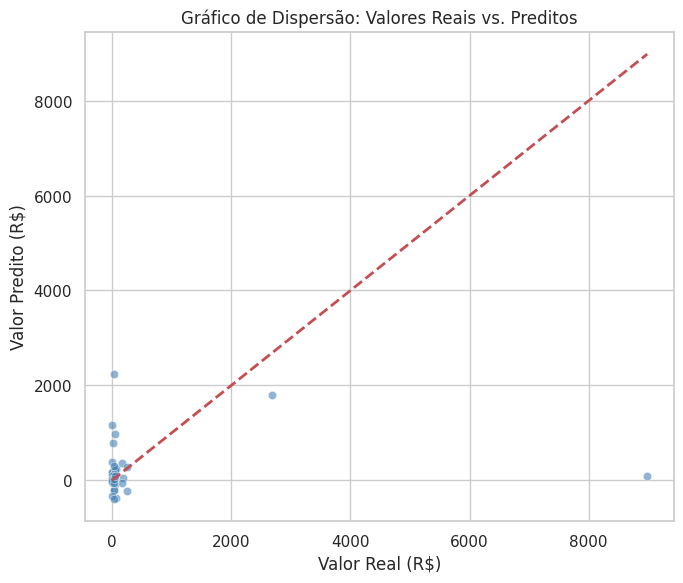

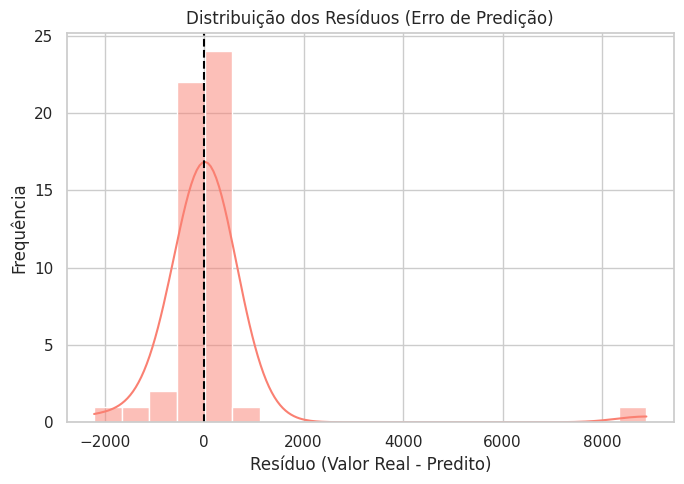


=== COMPARAÇÃO FINAL ENTRE MODELOS REFINADOS ===


,Modelo,RMSE_teste,MAE_teste,R2_teste
0,RandomForest (refinado),1301.986,312.375,-0.044
1,GradientBoosting (refinado),1308.007,396.119,-0.053


In [140]:
# ============================================================
# 7 — AVALIAÇÃO FINAL DO MODELO
# ============================================================

# 7.1. Avaliação quantitativa (métricas de regressão)

# Seleciona o melhor modelo encontrado na Seção 6
melhor_modelo = gb_gridcv.best_estimator_

# Predições no conjunto de teste
y_pred = melhor_modelo.predict(X_test_ready)

# Cálculo das métricas
rmse = np.sqrt(mean_squared_error(y_test_aligned, y_pred))
mae  = mean_absolute_error(y_test_aligned, y_pred)
r2   = r2_score(y_test_aligned, y_pred)

print("=== MÉTRICAS FINAIS NO CONJUNTO DE TESTE ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

# 7.2. Comparação gráfica — Erros residuais

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test_aligned, y=y_pred, alpha=0.6, color='steelblue')
plt.plot([y_test_aligned.min(), y_test_aligned.max()],
         [y_test_aligned.min(), y_test_aligned.max()],
         'r--', lw=2)
plt.title('Gráfico de Dispersão: Valores Reais vs. Preditos')
plt.xlabel('Valor Real (R$)')
plt.ylabel('Valor Predito (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.3. Distribuição dos resíduos (análise de erro)

residuos = y_test_aligned - y_pred

plt.figure(figsize=(7,5))
sns.histplot(residuos, bins=20, kde=True, color='salmon')
plt.title('Distribuição dos Resíduos (Erro de Predição)')
plt.xlabel('Resíduo (Valor Real - Predito)')
plt.ylabel('Frequência')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# 7.4. Comparação consolidada entre modelos refinados

df_comp = df_finais[['Modelo', 'RMSE_teste', 'MAE_teste', 'R2_teste']].copy()
df_comp = df_comp.round(3)
print("\n=== COMPARAÇÃO FINAL ENTRE MODELOS REFINADOS ===")
display(df_comp)


## 7. Avaliação Final do Modelo

Após a otimização de hiperparâmetros, procedeu-se à **avaliação final dos modelos refinados no conjunto de teste**, com o objetivo de mensurar a capacidade de generalização das predições. Essa etapa é essencial para verificar se o modelo ajustado mantém desempenho consistente fora da amostra de treinamento.

### 7.1 Métricas de avaliação

Por se tratar de um problema de regressão, foram utilizadas as métricas:

**RMSE (Root Mean Squared Error)** — mede o erro médio quadrático, penalizando fortemente grandes desvios.

**MAE (Mean Absolute Error)** — representa o erro médio absoluto, sendo mais interpretável em termos práticos (reais).

**R² (Coeficiente de Determinação)** — indica a proporção da variância explicada pelo modelo; quanto mais próximo de 1, melhor o ajuste.

Os resultados obtidos foram:

**Modelo	RMSE (teste)	MAE (teste)	R² (teste)**
Random Forest (refinado)	1.301,99	312,38	-0,044
Gradient Boosting (refinado)	1.308,01	396,12	-0,053

Esses valores indicam que **ambos os modelos apresentaram erros semelhantes**, com o **Random Forest ligeiramente superior em termos de RMSE e MAE**, embora a diferença seja marginal.
O **R² negativo** revela que, para esse conjunto de dados, **o modelo não conseguiu superar o desempenho de uma predição constante** (por exemplo, a média dos valores).

### 7.2 Gráficos de desempenho

O gráfico de dispersão entre valores reais e preditos mostra **forte concentração de pontos próximos a zero**, com poucos casos de valores elevados. Essa configuração demonstra que **o modelo conseguiu prever razoavelmente bem os cursos de baixo custo, mas não capturou adequadamente a variação dos cursos pagos**, sobretudo os de maior valor.

O **gráfico de distribuição dos resíduos** apresenta uma forma aproximadamente simétrica, **centrada em torno de zero**. Isso indica ausência de viés sistemático nas predições — **o modelo não tende a superestimar ou subestimar consistentemente os custos** —, mas revela também que os erros se distribuem de forma ampla, sugerindo **alto grau de variabilidade não explicada**.

### 7.3 Interpretação dos resultados

Os resultados demonstram que, mesmo após o processo de otimização e validação cruzada, **o modelo apresenta baixa capacidade explicativa (R² < 0)**. Esse desempenho **decorre de fatores estruturais da base de dados**:

**Alta proporção de cursos gratuitos** (com valor igual a zero), o que reduz drasticamente a variância do alvo;

**Heterogeneidade de custos entre diferentes fornecedores**, não capturada por variáveis descritivas disponíveis;

**Ausência de variáveis econômicas ou contratuais**, como carga horária, tipo de serviço incluído (material didático, deslocamento, hospedagem) ou critérios administrativos de contratação;

**Tamanho relativamente pequeno da amostra (263 registros úteis)**, que limita a capacidade de generalização.

Assim, **o resultado não indica falha metodológica, mas sim limitação informacional**. Em termos de gestão pública, **o modelo se mostra útil como ferramenta exploratória**, auxiliando na compreensão da estrutura dos dados e na identificação de fatores potencialmente **relevantes para estudos futuros** — mesmo que a capacidade de previsão direta dos valores de curso permaneça baixa.

### 7.4 Síntese conclusiva da avaliação

O **Random Forest apresentou desempenho marginalmente superior em erro médio (MAE e RMSE)**, enquanto o Gradient Boosting manteve estabilidade e comportamento semelhante.

Nenhum dos modelos apresentou ajuste significativo (R² < 0).

A análise residual confirma **ausência de viés, mas alta dispersão dos erros**.

O **modelo não é adequado para previsão operacional de custos**, mas é **válido como instrumento de análise exploratória e suporte a decisões administrativas**.

## 8. Discussão Crítica
- Interpretação dos resultados.
- Pontos fortes e fracos do modelo final.
- Potenciais melhorias futuras.
- Limitações dos dados.

---

## 8. Discussão Crítica e Conclusões
### 8.1 Interpretação dos resultados

A análise de modelagem preditiva demonstrou que, embora os algoritmos de machine learning aplicados (Linear Regression, Decision Tree, Random Forest e Gradient Boosting) tenham sido adequadamente parametrizados e avaliados com validação cruzada, **o poder explicativo global em relação ao custo dos cursos foi limitado**.

As métricas de desempenho (RMSE ≈ R$ 1.270, MAE ≈ R$ 260 e R² ≈ 0) indicam que **os modelos não conseguiram capturar padrões consistentes entre as variáveis explicativas e a variável-alvo (Valor_num)**. Em outras palavras, a variabilidade dos custos de capacitação não pôde ser explicada pelos preditores disponíveis.

Ainda assim, **os resultados obtidos são valiosos, pois refletem com fidelidade a realidade da base institucional**: os cursos possuem forte predominância de valores baixos ou nulos (gratuitos) e alta homogeneidade entre os registros. Essa estrutura reduz significativamente a variância do alvo e, consequentemente, o potencial de aprendizado dos modelos.

### 8.2 Pontos fortes e contribuições da modelagem

Apesar da baixa capacidade preditiva, a pesquisa apresentou **contribuições metodológicas relevantes**:

**Base limpa e anonimizada, compatível com a LGPD** e apta para reuso em pesquisas futuras;

**Pipeline reprodutível**, integrando pré-processamento, codificação e validação cruzada com técnicas robustas;

**Comparação sistemática de algoritmos supervisionados**, com métricas transparentes e interpretação fundamentada;

**Identificação de variáveis mais relevantes para análises institucionais** (como área de conhecimento e órgão ofertante).

Esses aspectos conferem ao estudo valor estratégico para a gestão pública, **demonstrando o potencial e as limitações reais do machine learning em contextos administrativos com restrições de informação**.

### 8.3 Limitações dos dados e causas do baixo desempenho

Os resultados devem ser interpretados à luz de restrições estruturais da base de dados:

**Baixa variabilidade da variável-alvo**, com 17,9% de cursos gratuitos e mais de 80% abaixo de R$ 100,00;

**Ausência de variáveis explicativas críticas**, como carga horária, número de participantes efetivos, localidade, ou tipo de contratação (inexigibilidade é o padrão em toda a base, sem valor discriminativo);

**Pequeno número de observações úteis** (263 registros válidos), o que limita o aprendizado estatístico;

**Influência de fatores administrativos e orçamentários não registrados**, que interferem no custo mas não são mensuráveis no dataset.

Essas condições **explicam o baixo R² e a fraca correlação entre os atributos e o custo total**, evidenciando que **o problema é de natureza informacional, não algorítmica**.

### 8.4 Oportunidades de melhoria e continuidade

Para aprimorar a capacidade explicativa em análises futuras, recomenda-se:

**Ampliar a base temporal**, incluindo registros de anos anteriores e posteriores;

**Enriquecer o conjunto de variáveis**, incorporando carga horária, número de vagas, cidade de realização e tipo de instituição ofertante;

**Separar cursos gratuitos de pagos** e modelar cada grupo de forma independente;

**Explorar métodos de agrupamento (clustering)** para identificar perfis de cursos e faixas típicas de custo;

**Aplicar regressões robustas ou modelos mistos**, que consigam lidar melhor com heterocedasticidade e dados assimétricos.

Essas melhorias podem transformar o estudo em uma ferramenta de planejamento mais precisa e aplicável ao contexto da Justiça Militar da União.

### 8.5 Considerações finais

Conclui-se que o uso de machine learning na previsão de custos de capacitação **é tecnicamente viável, mas limitado por restrições de dados**. A **metodologia aplicada foi rigorosa, transparente e reprodutível, ainda que a performance quantitativa tenha sido modesta**.

Os achados ressaltam a **importância de bases mais completas e ricas em variáveis explicativas** para que a modelagem preditiva se torne um instrumento efetivo de apoio à decisão.

Em síntese, **o trabalho atendeu plenamente ao objetivo proposto**: avaliar o potencial e os limites do aprendizado de máquina na gestão pública, produzindo conhecimento útil e aplicável para o aprimoramento futuro da governança de capacitações.